In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#fpath = '../../resources/AD-single-cell/41586_2019_1195_MOESM4_ESM.xlsx'
def read_DEsc(celltype='Mic', fpath='../../resources/AD-single-cell/41586_2019_1195_MOESM4_ESM.xlsx'):
    usecols = [11, 16, 17, 19]
    names = ['Gene', 'MixedModel.z', 'MixedModel.p', 'DEGs.Ind.Mix.models']
    df = pd.read_excel(fpath, sheet_name=celltype, skiprows=[0], usecols=usecols, index_col=0, names=names).dropna()
    df = df.astype({'DEGs.Ind.Mix.models': bool})
    return(df)

DEsc = {celltype: read_DEsc(celltype) for celltype in ['Ex', 'In', 'Ast', 'Oli', 'Opc', 'Mic']}

In [3]:
def read_DEip(celltype='Neuron', dirpath='../../results/2021-12-08-apoe-de-genes-tunahan/'):
    fpath = dirpath + celltype + '-apoe-de'
    with open(fpath, 'r') as f:
        genes = f.readlines()
    genes = [s.strip() for s in genes]
    return(genes)

DEip = {celltype: read_DEip(celltype) for celltype in ['Neuron', 'Astrocyte', 'Microglia-like']}

In [4]:
def sc_vs_ip(celltype_sc='Ex'):
    df = DEsc[celltype_sc]
    for celltype_ip in ['Neuron', 'Astrocyte', 'Microglia-like']:
        df['DE in ipsc ' + celltype_ip] = df.index.isin(DEip[celltype_ip])
    return(df)

DEsc = {celltype: sc_vs_ip(celltype) for celltype in DEsc.keys()}

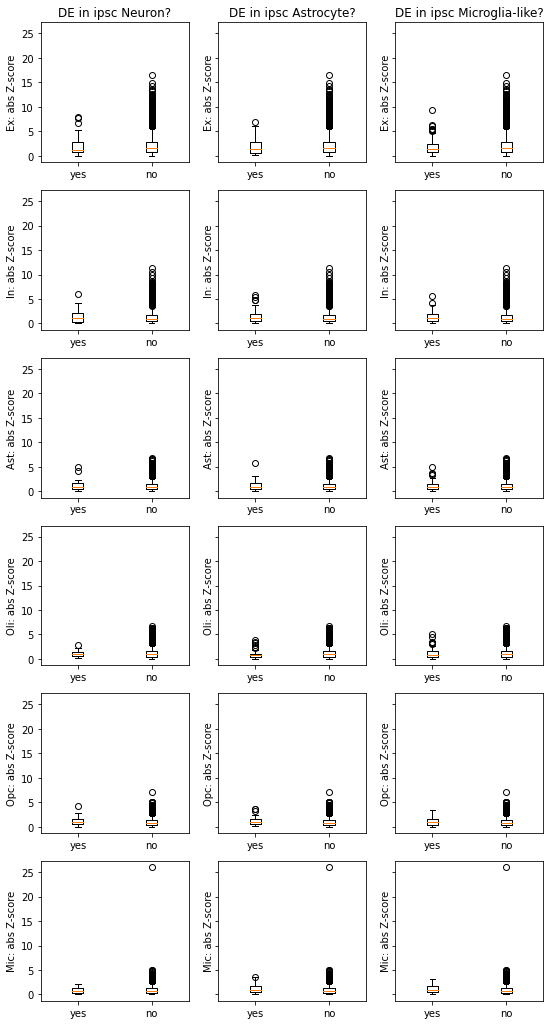

In [5]:
def my_boxplot(ax, celltype_sc='Ex', celltype_ip='Neuron', zscore=True):
    if zscore:
        supported = DEsc[celltype_sc].loc[DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.z'].abs()
        not_supported = DEsc[celltype_sc].loc[~ DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.z'].abs()
    else:
        supported = DEsc[celltype_sc].loc[DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.p']
        not_supported = DEsc[celltype_sc].loc[~ DEsc[celltype_sc]['DE in ipsc ' + celltype_ip], 'MixedModel.p']
    ax.boxplot([supported, not_supported])
    ax.set_xticklabels(['yes', 'no'])
    ax.set_ylabel(celltype_sc + ': abs Z-score')
    if not zscore:
        ax.set_yscale('log')
    return(ax)

#supported, not_supported = my_boxplot()
fig, ax = plt.subplots(len(DEsc.keys()), 3, sharey=True, sharex=False, figsize=(9, 18))
for celltype_sc, row in zip(DEsc.keys(), np.arange(len(DEsc.keys()))):
    for celltype_ip, axi in zip(['Neuron', 'Astrocyte', 'Microglia-like'], ax[row, :]):
        if row == 0:
            axi.set_title('DE in ipsc ' + celltype_ip + '?')
        axi = my_boxplot(axi, celltype_sc=celltype_sc, celltype_ip=celltype_ip)

In [7]:
%connect_info

{
  "shell_port": 55169,
  "iopub_port": 55170,
  "stdin_port": 55171,
  "control_port": 55173,
  "hb_port": 55172,
  "ip": "127.0.0.1",
  "key": "006612dc-c5adcd6c43ab34cf83f1a504",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-81598780-9d9b-4740-ae94-ee15d5a459cb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
